In [96]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler

#### Importing Dataset from Yahoo Finance

**Common Tickers include: ['FB','AMZN','GOOG','TWTR','TSLA']**

In [97]:
import yfinance as yf
stock_symbol = 'TWTR'
data = yf.download(tickers=stock_symbol,period='2y',interval='1d')
data = data.reset_index()
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
500,2022-03-18,37.459999,39.049999,37.180000,37.770000,37.770000,35938500
501,2022-03-21,37.700001,37.889999,36.639999,37.439999,37.439999,20298700
502,2022-03-22,37.639999,39.049999,37.619999,38.430000,38.430000,17162100
503,2022-03-23,38.000000,38.750000,37.580002,38.000000,38.000000,12993600
504,2022-03-24,38.330002,39.090000,38.230000,38.820000,38.820000,17819845


#### Visualizing the Real Stock Trend

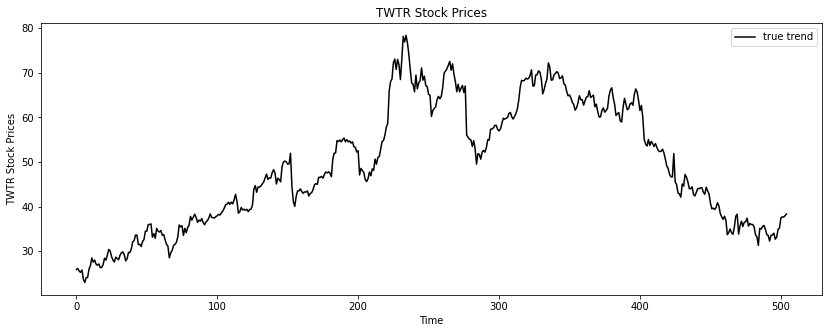

In [98]:
plt.figure(figsize=(14,5))
plt.plot(data['Open'],color='black',label='true trend')
plt.title('%s Stock Prices'%stock_symbol)
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

#### Marking a training timeframe of 60 days

In [99]:
test_size = 60
data_train = data[:-test_size]
data_test = data[-test_size:]
data.shape,data_train.shape,data_test.shape

((505, 7), (445, 7), (60, 7))

#### Preparing the training data

In [100]:
training_data = data_train.drop(['Date','Adj Close'],axis=1)
training_data.head()

,Open,High,Low,Close,Volume
0,25.850000,27.459999,24.520000,25.969999,25738800
1,26.150000,27.030001,25.629999,26.410000,20435300
2,25.559999,25.830000,24.760000,25.290001,22069300
3,25.250000,25.940001,24.600000,25.590000,20720800
4,25.790001,26.330000,24.400000,24.559999,24993400


In [101]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data[0]

array([0.05148122, 0.06786775, 0.04023095, 0.05401939, 0.20829276])

In [102]:
# Preparing the training set
x_train = []
y_train = []

for i in range(test_size, training_data.shape[0]):
    x_train.append(training_data[i-test_size:i])
    y_train.append(training_data[i,0])
# last 60 days will be the training set - X
# 61st day is the target value - Y

x_train = np.array(x_train)
y_train = np.array(y_train)

x_train.shape,y_train.shape
# 385 rows
# 60 columns
# 5 dimentional data

((385, 60, 5), (385,))

#### Preparaing testing data

In [103]:
past_test_days = data_train.tail(test_size)
df = pd.concat([past_test_days,data_test])
df = df.drop(['Date','Adj Close'],axis='columns')
df.shape, df.head()

C:\Users\Karen Pinto\AppData\Local\Temp\ipykernel_18084\2580858309.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = past_test_days.append(data_test,ignore_index = True)


((120, 5),
         Open       High        Low      Close    Volume
 0  61.040001  61.160000  57.639999  58.389999  17381300
 1  59.209999  60.669998  58.820000  59.860001  12006500
 2  58.950001  61.709999  58.790001  61.290001  10648100
 3  62.200001  64.360001  62.150002  63.970001  15010400
 4  64.250000  64.339996  63.310001  63.680000   8098800)

In [104]:
df = scaler.transform(df)
df[0]

array([0.68713874, 0.65733776, 0.65710555, 0.64768359, 0.12944366])

In [105]:
x_test = []
y_test = []

for i in range(test_size,df.shape[0]):
    x_test.append(df[i-test_size:i])
    y_test.append(df[i,0])

x_test, y_test = np.array(x_test),np.array(y_test)
x_test.shape, y_test.shape

((60, 60, 5), (60,))

#### Defining the Scaling Label

In [106]:
# below is the scaling label, 
# therefore we need to divide our y_pred with the below scaling value it used to scale the data
scaler.scale_

array([1.80635836e-02, 1.74916914e-02, 1.86254415e-02, 1.83116656e-02,
       9.43453190e-09])

In [107]:
scale = 1/8.50296711e-04
scale

1176.0600588751424

In [108]:
y_test = y_test*scale

### LSTM - Long Short-Term Memory

In [109]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [110]:
x_train.shape[1],x_train.shape[2]

(60, 5)

In [111]:
regression = Sequential()

# 1st layer
regression.add(LSTM(units=40,activation='relu',return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
regression.add(Dropout(0.2))

# 2nd layer
regression.add(LSTM(units=60,activation='relu',return_sequences=True))
regression.add(Dropout(0.2))

# 3rd layer
regression.add(LSTM(units=80,activation='relu',return_sequences=True))
regression.add(Dropout(0.2))

# Final layer
regression.add(LSTM(units=120,activation='relu'))
regression.add(Dropout(0.5))

regression.add(Dense(units=1))

regression.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 40)            7360      
                                                                 
 dropout_12 (Dropout)        (None, 60, 40)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 60)            24240     
                                                                 
 dropout_13 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_14 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_15 (LSTM)              (None, 120)              

In [112]:
regression.compile(optimizer='adam',loss='mean_squared_error')

In [113]:
def forecast():
    regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred*scale
    return y_pred

In [114]:
def first_forecast():
    history = regression.fit(x_train,y_train,epochs=300,batch_size=32)
    y_pred = regression.predict(x_test)
    y_pred = y_pred*scale
    return history,y_pred

In [115]:
result_forecast = []
simulation = 1
print("Simulation 1")
history,first_result = first_forecast()
result_forecast.append(first_result)
for i in range(1,simulation):
    print("Simulation %d"%(i+1))
    result_forecast.append(forecast())


Simulation 1
Epoch 1/300


#### Calculating the Accuracy using RMSE

In [ ]:
# MAPE - Mean Absolute Percentage Error
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    # mean Absolute Percentage Error - MAPE
    percentage = 1 - np.mean(np.abs((real-predict)/real))
    return percentage * 100
mean_accuracy = []
for i in range(simulation):
    mean_accuracy.append(calculate_accuracy(y_test, result_forecast[i]))

mean_accuracy

[-11.139132499877169]

In [ ]:
# RMSE - Root Mean Squared Error 
temp = 1 - np.sqrt(np.mean(np.square((y_test - result_forecast[0])/y_test)))
temp*100

#### Visualization

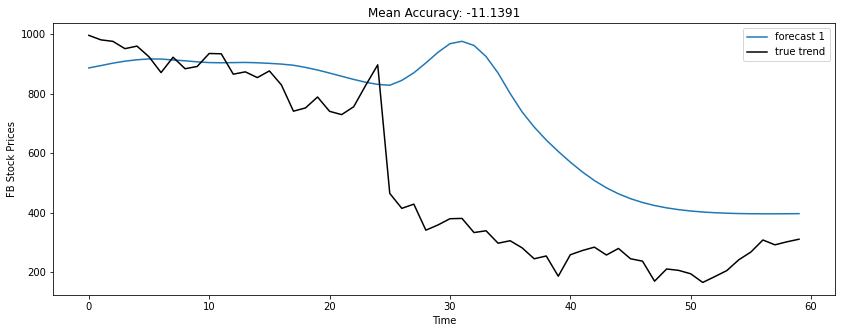

In [ ]:
plt.figure(figsize=(14,5))
for i in range(simulation):
    plt.plot(result_forecast[i],label='forecast %d'%(i+1))
plt.plot(y_test,color='black',label='true trend')
plt.title('Mean Accuracy: %.4f'%np.mean(mean_accuracy))
plt.xlabel('Time')
plt.ylabel('%s Stock Prices'%stock_symbol)
plt.legend()
plt.show()

In [ ]:
history.history.keys()

2/2 [==============================] - 0s 26ms/step - loss: 366911.4688


366911.46875

In [ ]:
plt.plot(history.history['accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('LSTM Model, Accuracy vs Epoch')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('LSTM Model Model, Loss vs Epoch')
plt.show()